Steps are:

- select a reconstruction time
- the code determines which paleogeography stage this falls within, gets the start and end times
- load the relevant precomputed multipoint files, and in the process assign an integer to the different types for use in interpolation steps (e.g. set land to be 1, shallow marine to be 2, etc)

- for land and marine



In [1]:
import pygplates
import glob, re
import numpy as np
import matplotlib.pyplot as plt

import polygon_processing as pp
import paleogeography as pg
import paleogeography_tweening as pgt

from proximity_query import *
from create_gpml import create_gpml_regular_long_lat_mesh
import points_in_polygons
from sphere_tools import sampleOnSphere
import points_spatial_tree



%matplotlib inline


reconstruction_time = 50.

reconstruction_basedir = '/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'

tween_basedir = './tween_feature_collections/'



sampling = 1.0

rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % reconstruction_basedir,
                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % reconstruction_basedir])



# make a sorted list of the (midpoint) times for paleogeography polygons
tmp = glob.glob('%s/*/' % reconstruction_basedir)

time_list = []
for tm in tmp:
    time_list.append(float(re.findall(r'\d+Ma+',tm)[1][:-2]))

time_list.sort()

time_list = np.array(time_list)

# find times that bracket the selected exact time in the paleogeography source files
time_stage_max = time_list[np.where(time_list>reconstruction_time)[0][0]]
time_stage_min = time_list[np.where(time_list<reconstruction_time)[0][-1]]


print 'Selected Time is in the stage %0.2fMa to %0.2fMa' % (time_stage_min,time_stage_max)


land_points_file = '%s/tweentest_land_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
marine_points_file = '%s/tweentest_ocean_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
mountains_going_up_file = '%s/mountain_transgression_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
mountains_going_down_file = '%s/mountain_regression_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
mountains_stable_file = '%s/mountain_stable_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)



Selected Time is in the stage 45.00Ma to 53.00Ma


In [2]:
# define a function that loads paleogeography multipoints at a specified time
# NOTE this time can be anything, not a time where the multipoints fit nicely together,
# hence the gaps and overlaps will be present
def add_reconstructed_points_to_xyz(points_file,rotation_model,reconstruction_time,zval):
    
    reconstructed_points = []
    pygplates.reconstruct(points_file,rotation_model,reconstructed_points,reconstruction_time)
    
    point_array = []
    for reconstructed_point in reconstructed_points:
        point_array.append(reconstructed_point.get_reconstructed_geometry().to_lat_lon_array())
        
    xy_array = np.vstack(point_array)
    #print np.ones((xy_array.shape[0],1))
    xyz_array = np.hstack((xy_array,zval*np.ones((xy_array.shape[0],1))))
    
    return xyz_array



land_point_array = add_reconstructed_points_to_xyz(land_points_file,rotation_model,reconstruction_time,200)
marine_point_array = add_reconstructed_points_to_xyz(marine_points_file,rotation_model,reconstruction_time,-200)

pg_point_array = np.vstack((land_point_array,marine_point_array))




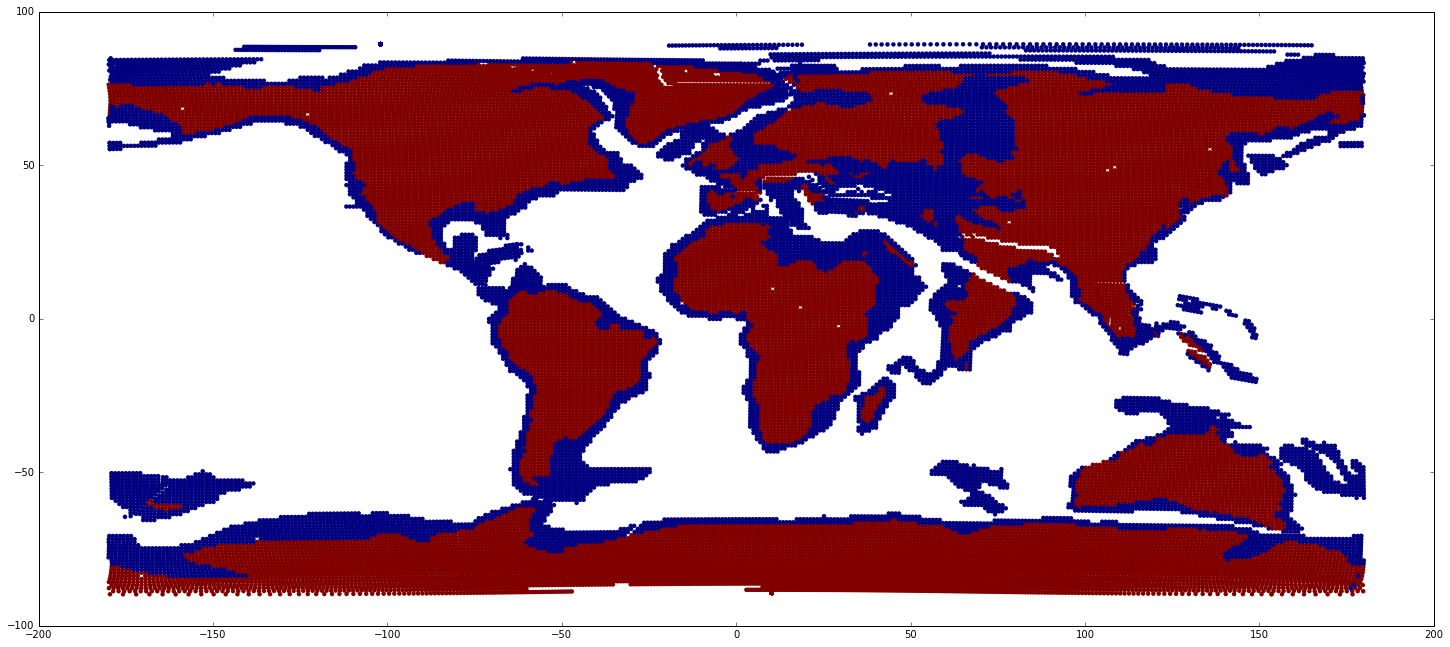

In [3]:
plt.figure(figsize=(25,11))
plt.scatter(pg_point_array[:,1],pg_point_array[:,0],c=pg_point_array[:,2],edgecolor='')


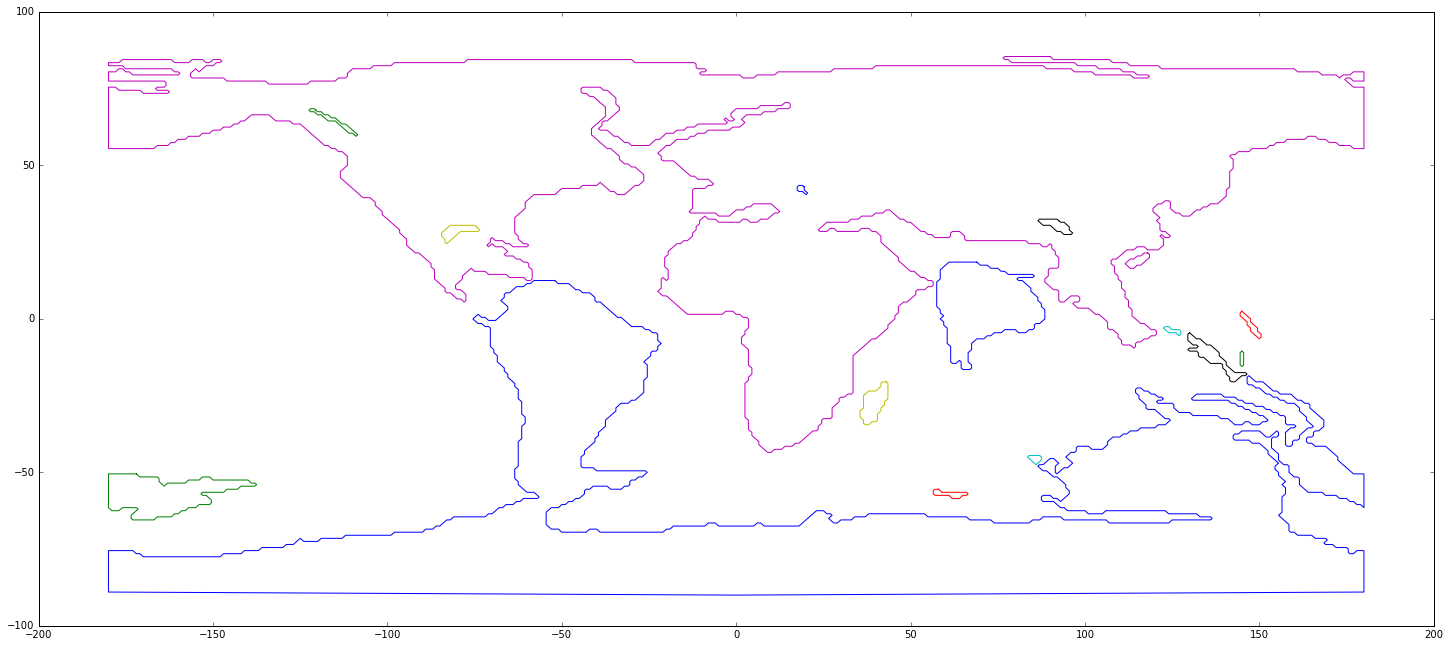

In [4]:
# This cell uses COB Terranes to make a masking polygon
# (which is called 'seive_polygons')

area_threshold = 0.001

COBterrane_file = '/Users/Simon/Data/EByteSVN/EByteDeformingModels/Matthews++_410-0Ma/StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml'
polygon_features = pygplates.FeatureCollection(COBterrane_file)

cobter = pp.force_polygon_geometries(polygon_features)

cf = pp.merge_polygons(cobter,rotation_model,time=reconstruction_time,sampling=sampling)
sieve_polygons = pp.polygon_area_threshold(cf,area_threshold)

plt.figure(figsize=(25,11))
for polygon in sieve_polygons:
    plt.plot(polygon.get_geometry().to_lat_lon_array()[:,1],
             polygon.get_geometry().to_lat_lon_array()[:,0])
        

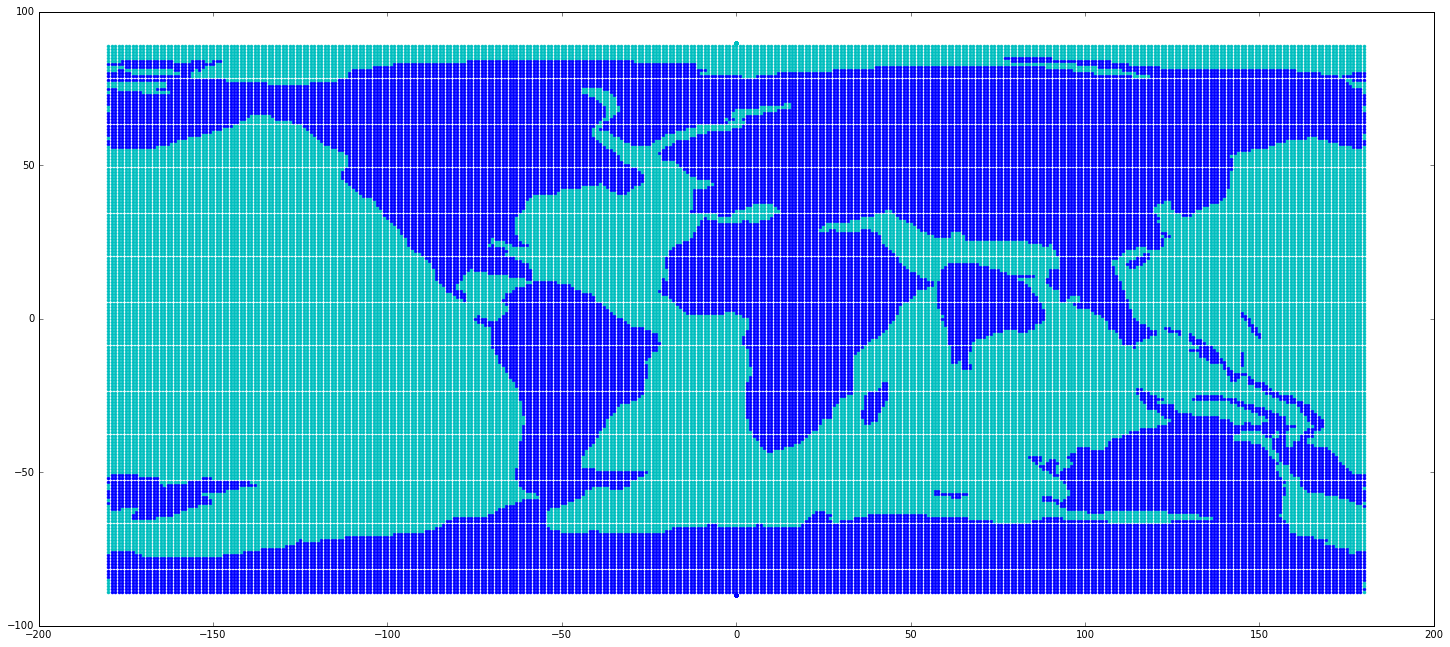

In [5]:
# use merged seive_polygons to get a regular lat-long multipoint that will contain points
# only within the COB Terranes (ie not within the 'deep ocean')

multipoints = create_gpml_regular_long_lat_mesh(sampling)
grid_dims = (int(180/sampling)+1,int(360/sampling)+1)

for multipoint in multipoints:
    for mp in multipoint.get_all_geometries():
        points = mp.to_lat_lon_point_list()

#reconstructed_polygons = []
#pygplates.reconstruct(cobter,rotation_model,reconstructed_polygons,reconstruction_time)

rpolygons = []
for polygon in sieve_polygons:
    if polygon.get_geometry():
        rpolygons.append(polygon.get_geometry())

polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

lat = []
lon = []
zval = []

lat_deep = []
lon_deep = []
zval_deep = []

for pcp,point in zip(polygons_containing_points,points):
    if pcp is not None:
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
    else:
        lat_deep.append(point.get_latitude())
        lon_deep.append(point.get_longitude())
        zval_deep.append(-2500.)


plt.figure(figsize=(25,11))
plt.plot(lon,lat,'b.')
plt.plot(lon_deep,lat_deep,'c.')


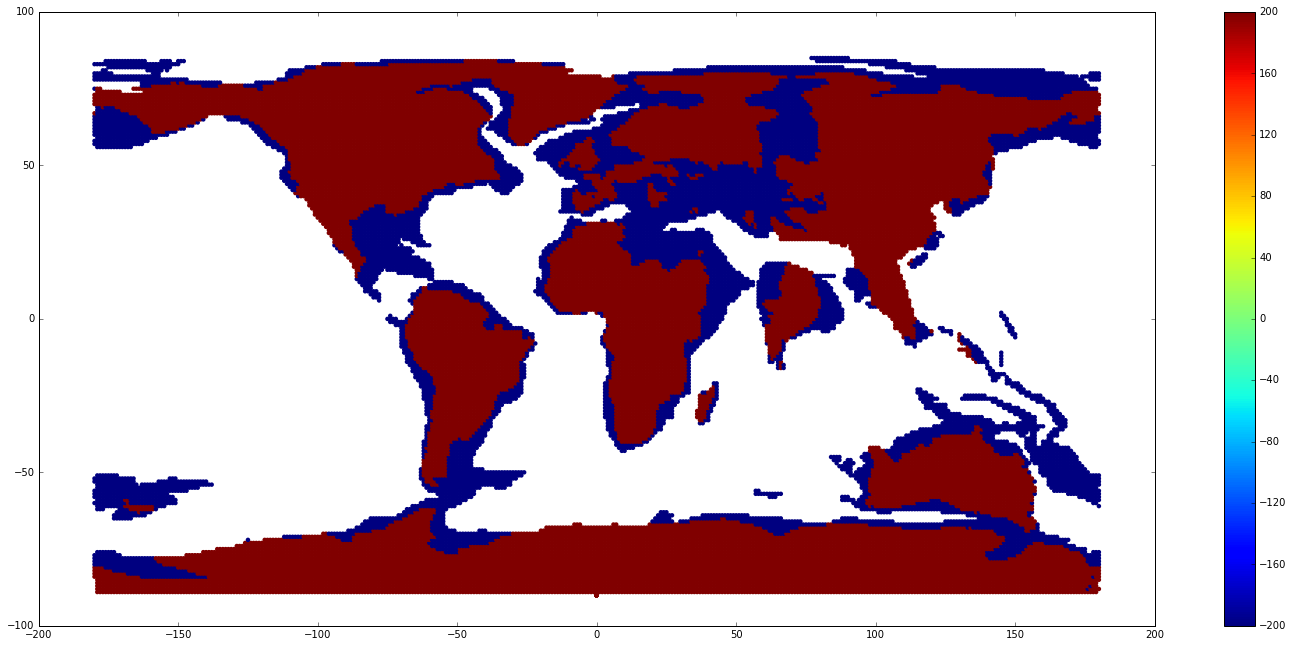

In [6]:
# sample the land/marine points onto the points within the COB Terranes
# This will fill the gaps that exist within continents, and average out overlaps

d,l = sampleOnSphere(pg_point_array[:,0],pg_point_array[:,1],pg_point_array[:,2],
                     np.array(lat),np.array(lon),n=1)

land_marine_interp_points = pg_point_array[:,2].ravel()[l]

plt.figure(figsize=(25,11))
plt.scatter(lon,lat,c=land_marine_interp_points,edgecolor='')
plt.colorbar()


In [7]:
## DEPRECATED - MIGHT BE USEFUL IF CAN WORK WITH SCALAR COVERAGES??
run=None
if run is not None:
    buffer_degrees = 1.

    dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,reconstruction_time,3)
    dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,reconstruction_time,3)
    dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,reconstruction_time,3)

    mountains_t1 = np.vstack((dat3,dat5))
    mountains_t2 = np.vstack((dat4,dat5))


    # for the mountains, the precomputed multipoints are not 'tweened', just get extent of mountains
    # at the beginning and end of each stage.
    # --> look at both time extremes so we can interpolate height at an intermediate time

    #print mountains_t1[:2,:]
    distance_threshold_radians=None

    mountain_points = pygplates.MultiPointOnSphere(zip(mountains_t1[:,0],mountains_t1[:,1]))

    res1 = find_closest_geometries_to_points([pygplates.PointOnSphere(point) for point in zip(dat1[:,0],dat1[:,1])],
                                             [mountain_points],
                                             distance_threshold_radians = distance_threshold_radians)

    distance_to_mountains = np.degrees(np.array(zip(*res1)[0]))


    plt.figure(figsize=(25,11))
    plt.scatter(dat1[:,1],dat1[:,0],c=distance_to_mountains,edgecolors='',vmin=0,vmax=5.)


    mountain_points = pygplates.MultiPointOnSphere(zip(mountains_t2[:,0],mountains_t2[:,1]))

    res1 = find_closest_geometries_to_points([pygplates.PointOnSphere(point) for point in zip(dat1[:,0],dat1[:,1])],
                                             [mountain_points],
                                             distance_threshold_radians = distance_threshold_radians)

    distance_to_mountains = np.degrees(np.array(zip(*res1)[0]))


    plt.figure(figsize=(25,11))
    plt.scatter(dat1[:,1],dat1[:,0],c=distance_to_mountains,edgecolors='',vmin=0,vmax=5.)

#plt.plot(mountains_t1[:,])


In [8]:
def get_distance_to_mountain_edge(point_array,reconstruction_basedir,time):
    
    distance_threshold_radians=None
    env_list = ['m']

    pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (reconstruction_basedir,time)

    pg_features = pg.load_paleogeography(pg_dir,env_list)
    cf = pp.merge_polygons(pg_features,rotation_model,time=time,sampling=0.25)
    sieve_polygons_t1 = pp.polygon_area_threshold(cf,area_threshold)

    polygons_as_list = []
    for feature in sieve_polygons_t1:
        polygons_as_list.append(feature.get_geometry())
        
    res1 = find_closest_geometries_to_points([pygplates.PointOnSphere(point) for point in zip(point_array[:,0],point_array[:,1])],
                                             polygons_as_list,
                                             distance_threshold_radians = distance_threshold_radians)

    #print res1
    
    distance_to_polygon_boundary = np.degrees(np.array(zip(*res1)[0]))


    # Make a copy of list of distances.
    distance_to_polygon = list(distance_to_polygon_boundary)

    # Set distance to zero for any points inside a polygon (leave other points unchanged).
    res2 = points_in_polygons.find_polygons([pygplates.PointOnSphere(point) for point in zip(point_array[:,0],point_array[:,1])],
                                            polygons_as_list)

        
    for point_index, rpolygon in enumerate(res2):
        # If not inside any polygons then result will be None.
        if rpolygon is None:
            distance_to_polygon[point_index] = 0.0
            
    return distance_to_polygon




In [9]:
dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,time_stage_max,3)
dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,time_stage_max,3)
dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,time_stage_max,3)

mountains_t2_point_array = np.vstack((dat3,dat4,dat5))

#print mountains_t2_point_array.shape

dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,time_stage_min,3)
dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,time_stage_min,3)
dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,time_stage_min,3)

mountains_t1_point_array = np.vstack((dat3,dat4,dat5))

#print mountains_t1_point_array.shape

dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,reconstruction_time,3)
dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,reconstruction_time,3)
dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,reconstruction_time,3)

mountains_tr_point_array = np.vstack((dat3,dat4,dat5))

#print mountains_tr_point_array.shape



['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


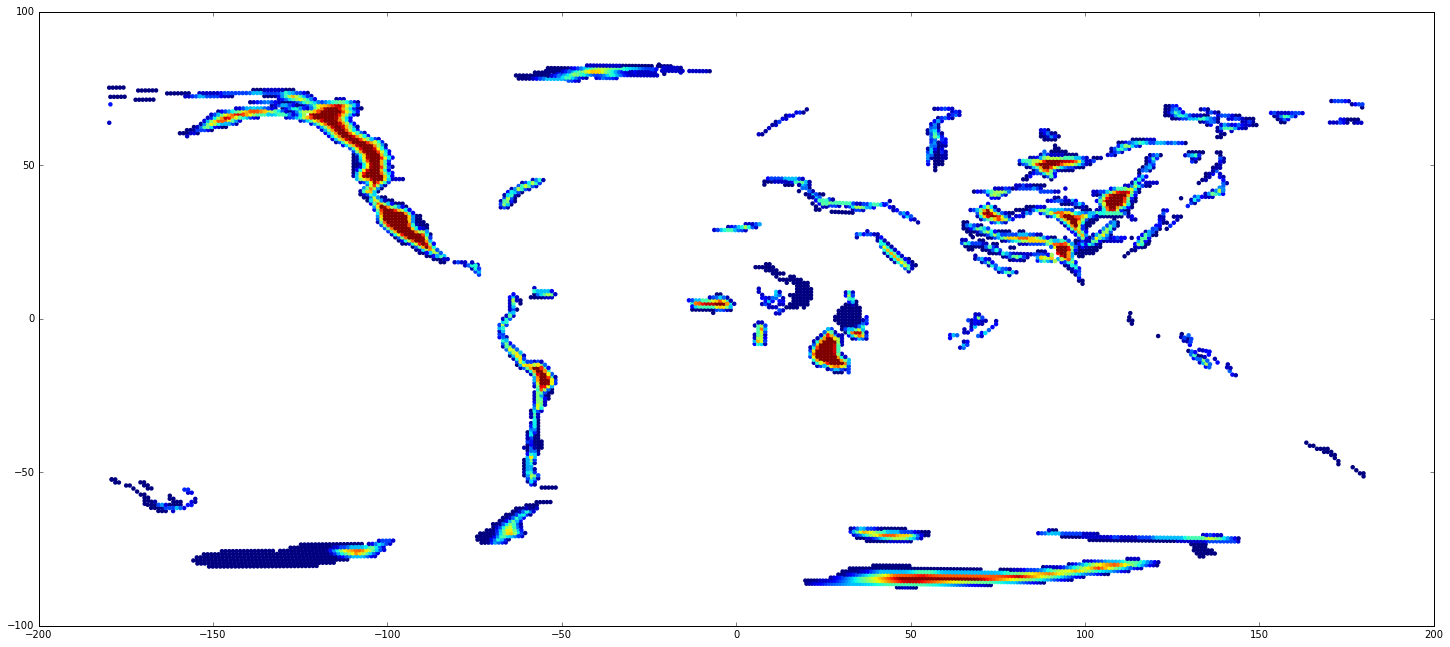

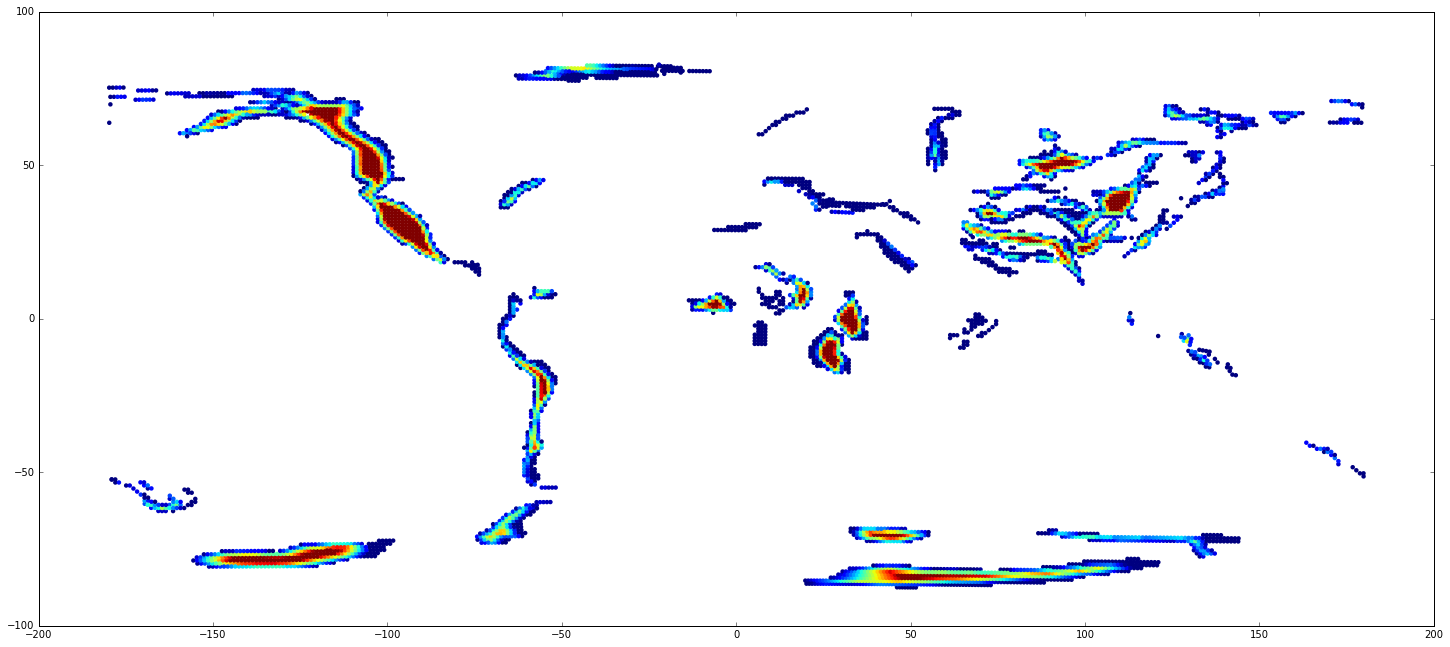

In [10]:
dist_t1 = get_distance_to_mountain_edge(mountains_t1_point_array,reconstruction_basedir,time_stage_min)

dist_t2 = get_distance_to_mountain_edge(mountains_t2_point_array,reconstruction_basedir,time_stage_max)


plt.figure(figsize=(25,11))
plt.scatter(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],c=dist_t1,edgecolors='',vmin=0,vmax=2.)

plt.figure(figsize=(25,11))
plt.scatter(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],c=dist_t2,edgecolors='',vmin=0,vmax=2.)




8.0 0.625


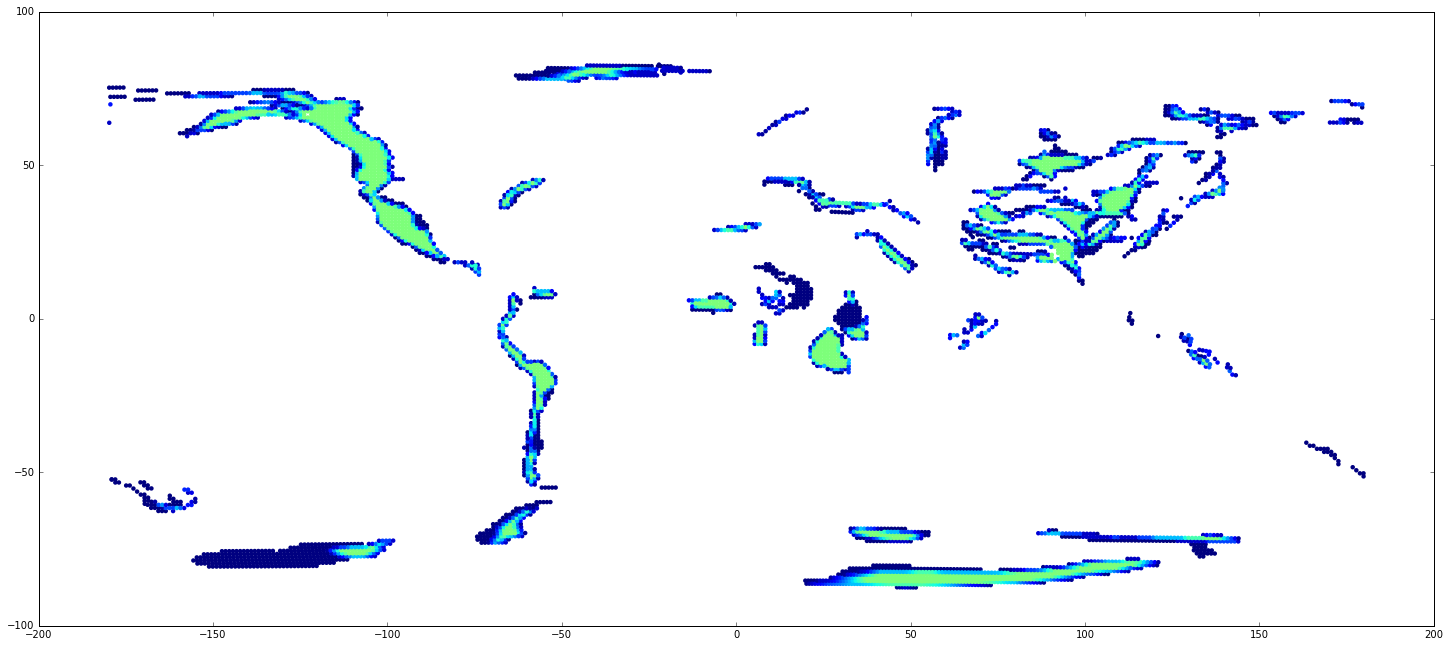

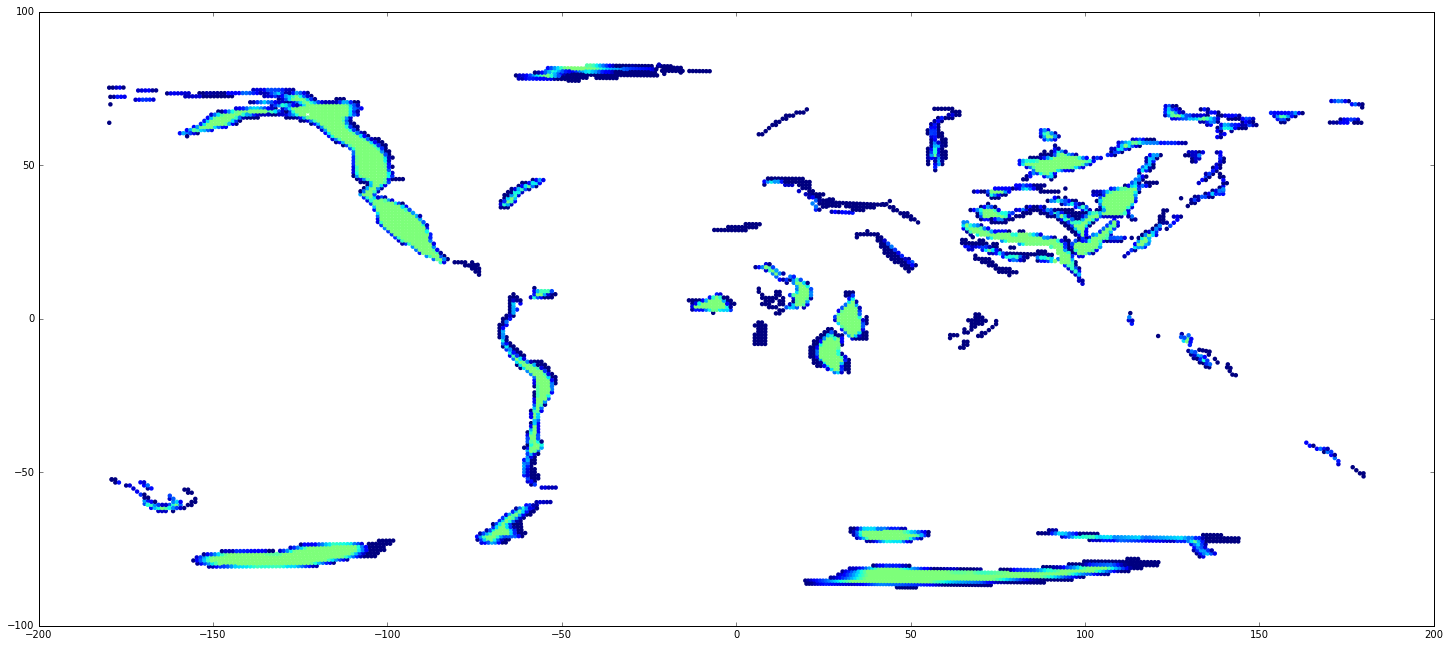

In [11]:
dist_t1_cap = np.array(dist_t1)
dist_t1_cap[np.array(dist_t1)>1.] = 1.

plt.figure(figsize=(25,11))
plt.scatter(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],c=dist_t1_cap,edgecolors='',vmin=0,vmax=2.)


dist_t2_cap = np.array(dist_t2)
dist_t2_cap[np.array(dist_t2)>1.] = 1.

plt.figure(figsize=(25,11))
plt.scatter(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],c=dist_t2_cap,edgecolors='',vmin=0,vmax=2.)


t_diff = (time_stage_max-time_stage_min)
t_norm = (reconstruction_time-time_stage_min)/t_diff
print t_diff, t_norm




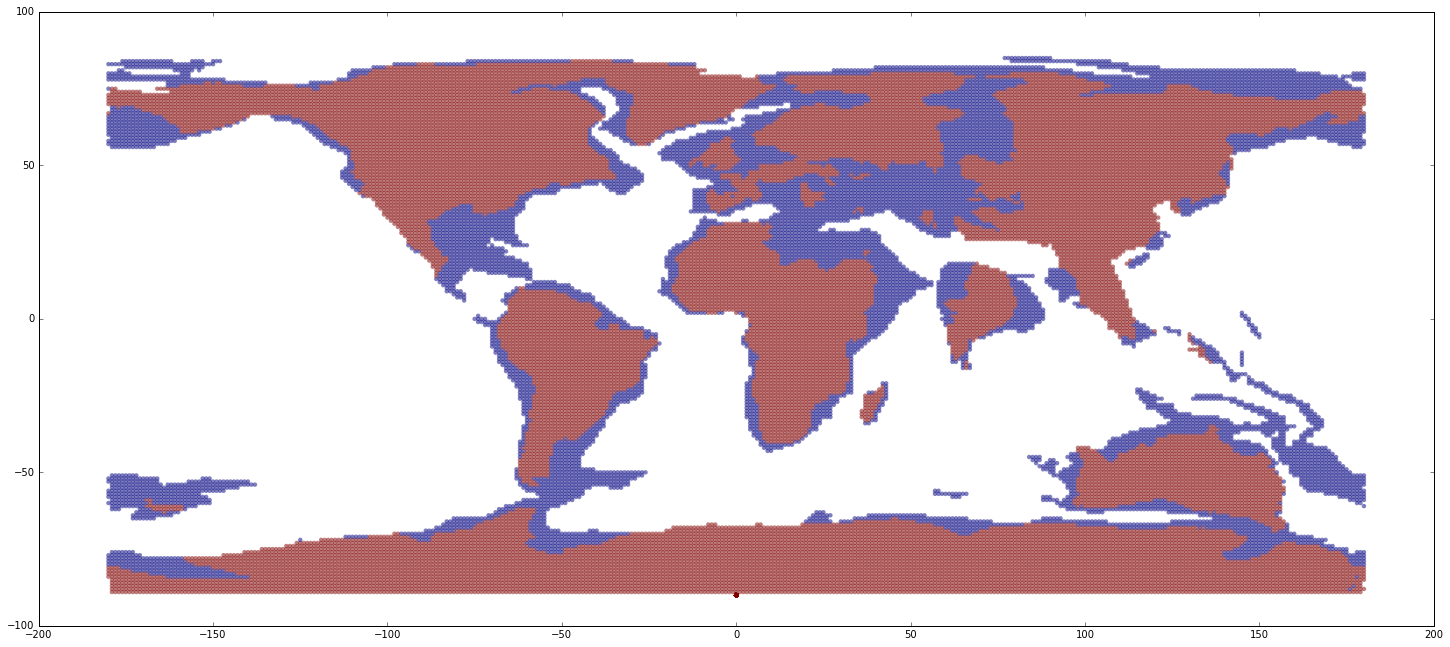

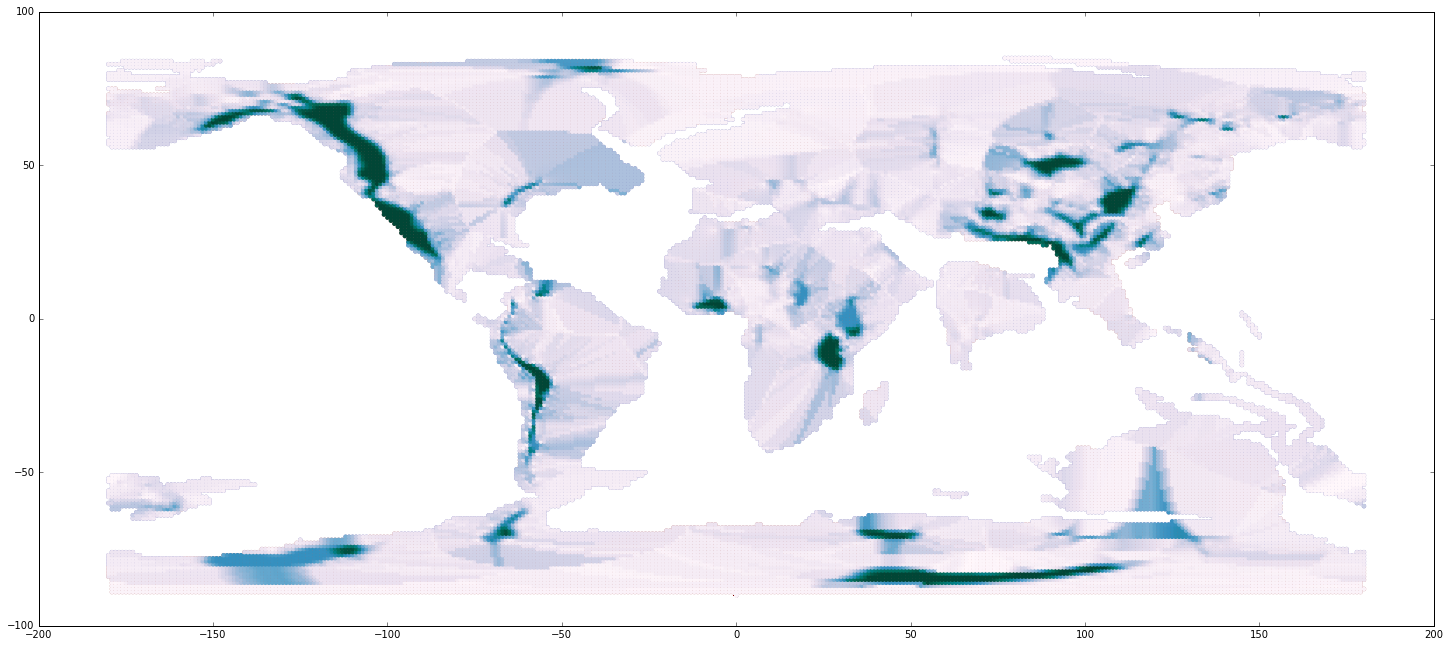

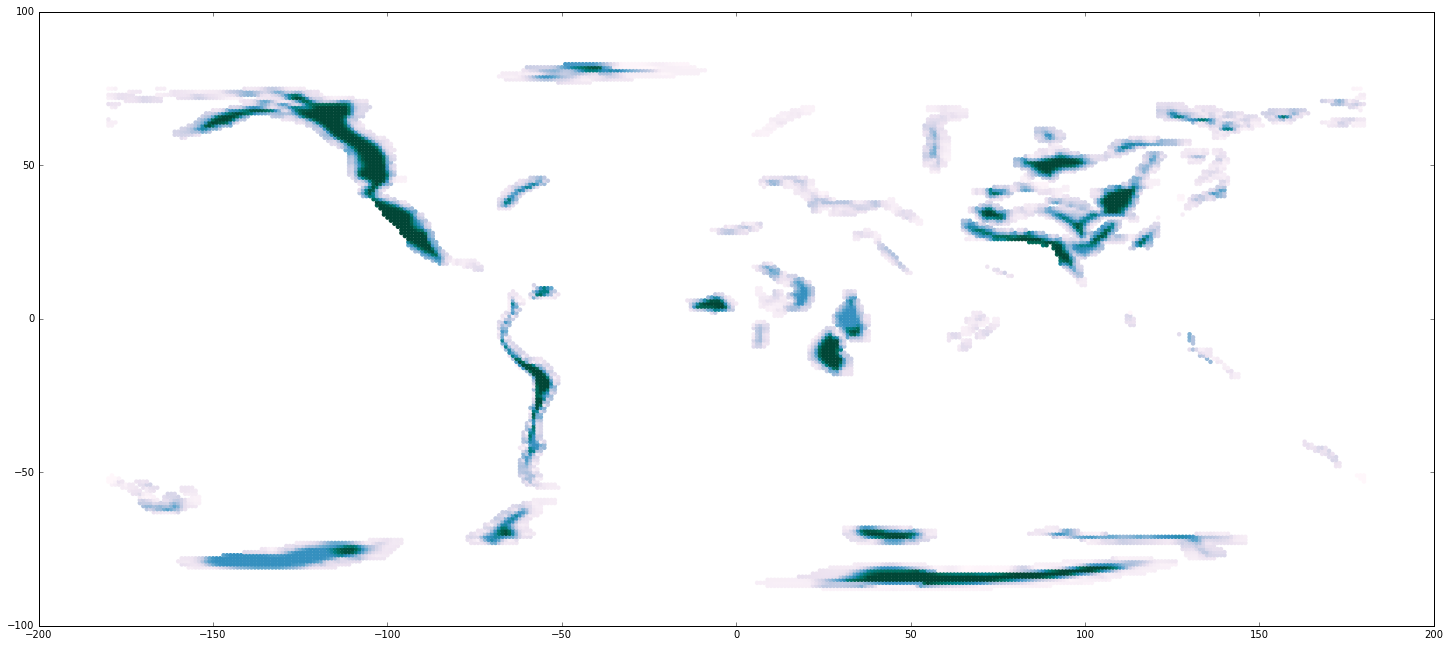

In [12]:
from scipy import interpolate

tmp = np.vstack((dist_t1_cap,dist_t2_cap))

f = interpolate.interp1d([0,1],tmp.T)

normalized_mountain_elevation = f(t_norm)



d,l = sampleOnSphere(mountains_tr_point_array[:,0],mountains_tr_point_array[:,1],normalized_mountain_elevation,
                     np.array(lat),np.array(lon),k=4)
w = 1./d**2
normalized_mountain_elevation_interp_points = np.sum(w * normalized_mountain_elevation.ravel()[l],axis=1) / np.sum(w,axis=1)

mountain_proximity_index = np.degrees(np.min(d,axis=1))<1.


plt.figure(figsize=(25,11))
plt.scatter(lon,lat,c=land_marine_interp_points,edgecolor='',alpha=0.5)

plt.figure(figsize=(25,11))
plt.scatter(lon,lat,c=land_marine_interp_points,edgecolor='',alpha=0.5)
#plt.scatter(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],c=normalized_mountain_elevation,edgecolors='',
#            vmin=0.0,vmax=1.,cmap=plt.cm.PuBuGn)
plt.scatter(lon,lat,c=normalized_mountain_elevation_interp_points,edgecolors='',
            vmin=0.0,vmax=1.,cmap=plt.cm.PuBuGn)

plt.figure(figsize=(25,11))
plt.scatter(np.array(lon)[mountain_proximity_index],
            np.array(lat)[mountain_proximity_index],
            c=normalized_mountain_elevation_interp_points[mountain_proximity_index],
            edgecolors='',vmin=0.0,vmax=1.,cmap=plt.cm.PuBuGn)



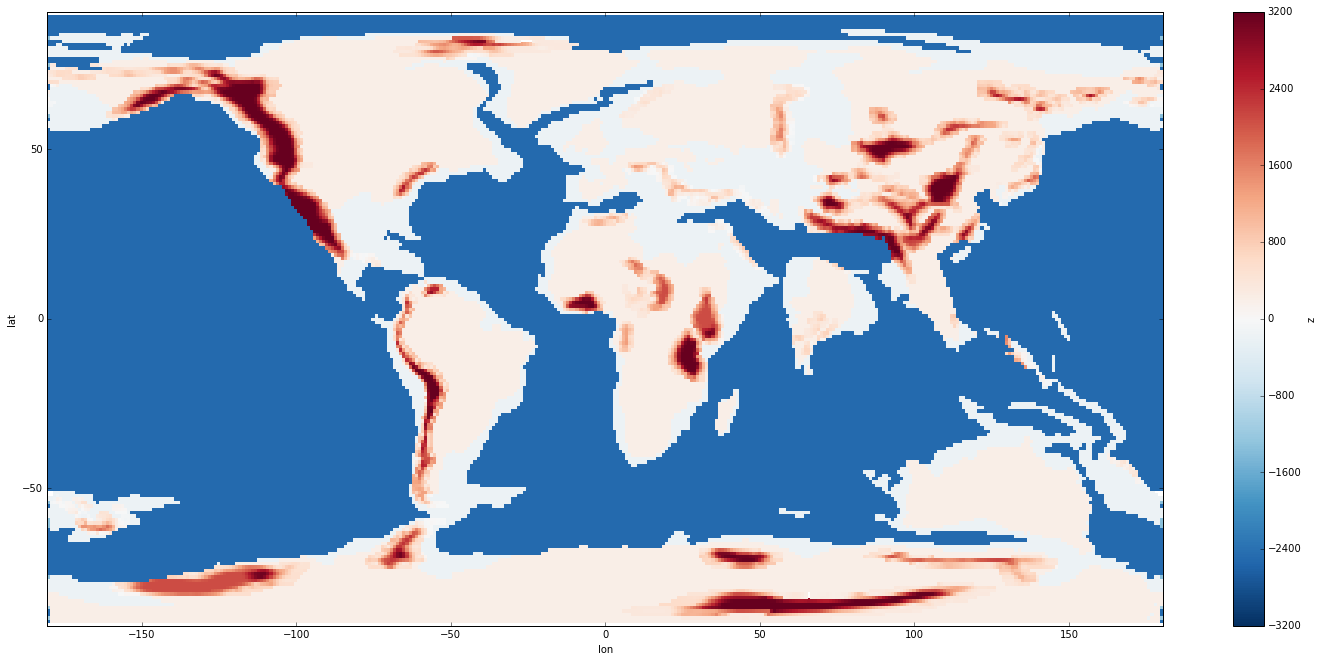

In [13]:
import os
import xarray as xr

def write_xyz_file(output_filename, output_data):
    with open(output_filename, 'w') as output_file:
        for output_line in output_data:
            output_file.write(' '.join(str(item) for item in output_line) + '\n')
            

write_xyz_file('land_marine.xyz',zip(lon+lon_deep,
                                     lat+lat_deep,
                                     np.hstack((land_marine_interp_points,zval_deep))))
write_xyz_file('mountain.xyz',zip(np.array(lon)[mountain_proximity_index],
                                  np.array(lat)[mountain_proximity_index],
                                  normalized_mountain_elevation_interp_points[mountain_proximity_index]*3000))

os.system('gmt xyz2grd land_marine.xyz -Gland_marine.nc -Rd -I%0.8f' % sampling)
os.system('gmt xyz2grd mountain.xyz -Gmountain.nc -Rd -I%0.8f -di0' % sampling)

os.system('gmt grdmath mountain.nc land_marine.nc ADD = paleotopo.nc')
#os.system('gmt grdmath mountain.nc 0 AND = paleotopo.nc -V')


ds_disk = xr.open_dataset('paleotopo.nc')

plt.figure(figsize=(25,11))
ds_disk['z'].plot()

ds_disk.close()

